Исходная длина ряда: 2075259
Часовая длина ряда: 34589

=== ADF тест: Часовой ряд ===
ADF Statistic: -14.26365551077736
p-value: 1.4126105961814462e-26
❗ Ряд СТАЦИОНАРЕН (отвергаем H0)

=== KPSS тест: Часовой ряд ===
Statistic: 1.2019322432755528
p-value: 0.01
❗ Ряд НЕ стационарен (отвергаем H0)


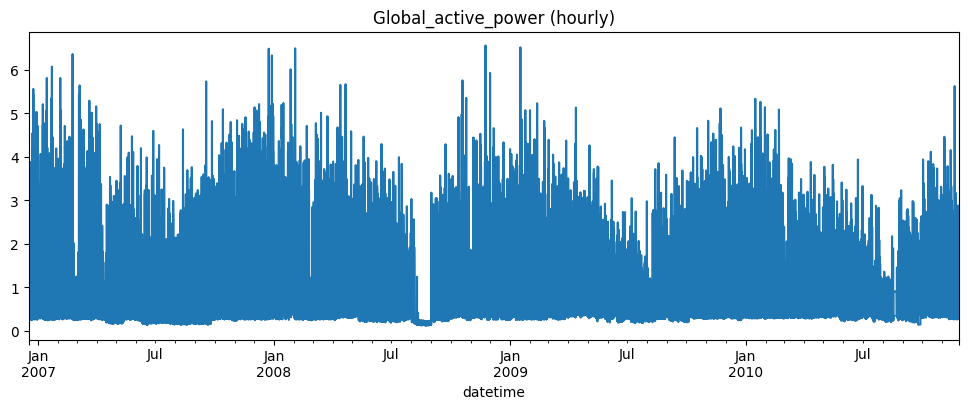

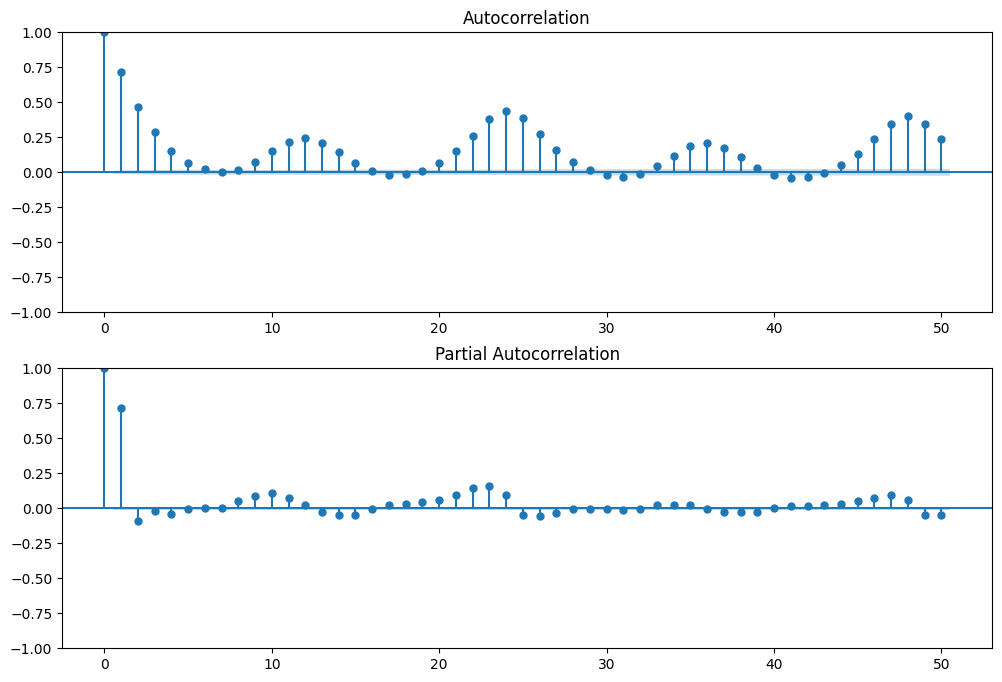


=== ADF / KPSS после разности ===

=== ADF тест: Разностный ряд ===
ADF Statistic: -42.83923546260636
p-value: 0.0
❗ Ряд СТАЦИОНАРЕН (отвергаем H0)

=== KPSS тест: Разностный ряд ===
Statistic: 0.023282369130979783
p-value: 0.1
❗ Ряд СТАЦИОНАРЕН


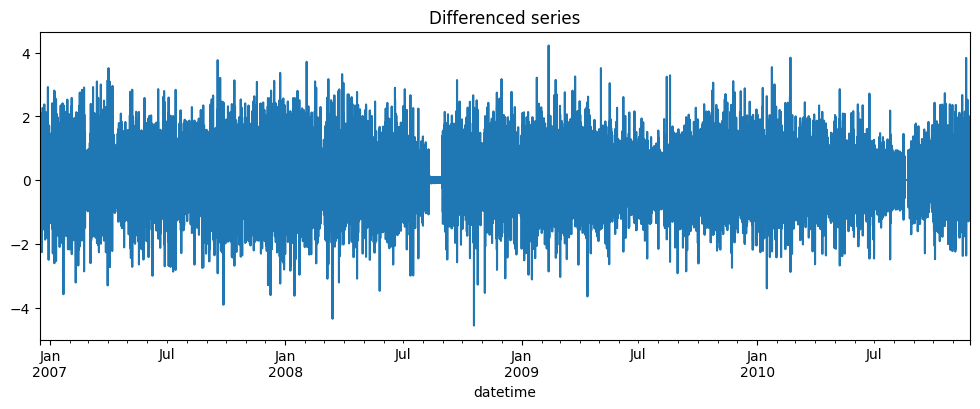

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# ===== 1. Загрузка с оптимизацией памяти =====
dtypes = {
    'Global_active_power': 'float32',
    'Global_reactive_power': 'float32',
    'Voltage': 'float32',
    'Global_intensity': 'float32',
    'Sub_metering_1': 'float32',
    'Sub_metering_2': 'float32',
    'Sub_metering_3': 'float32'
}

chunks = pd.read_csv(
    "archive/household_power_consumption.txt",
    sep=';',
    na_values=['?'],
    dtype=dtypes,
    chunksize=50000,   # читаем по частям
    on_bad_lines='skip'
)

# Объединяем чанки
df = pd.concat(chunks)

# Преобразуем дату и время в datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df = df.set_index('datetime')

# Удаляем старые колонки Date и Time
df = df.drop(columns=['Date', 'Time'], errors='ignore')

# Приводим все колонки к числовому типу и заполняем пропуски
df = df.apply(pd.to_numeric, errors='coerce').fillna(method='ffill')

# ===== 2. Агрегация до часовой частоты =====
ts = df['Global_active_power'].resample('1H').mean()

print("Исходная длина ряда:", len(df))
print("Часовая длина ряда:", len(ts))

# ===== 3. Функции тестов =====
def adf_test(series, title=""):
    print(f"\n=== ADF тест: {title} ===")
    result = adfuller(series.dropna(), autolag="AIC")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("❗ Ряд СТАЦИОНАРЕН (отвергаем H0)")
    else:
        print("❗ Ряд НЕ стационарен")
    return result[1]

def kpss_test(series, title=""):
    print(f"\n=== KPSS тест: {title} ===")
    statistic, p_value, _, _ = kpss(series.dropna(), regression='c', nlags="auto")
    print(f"Statistic: {statistic}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("❗ Ряд НЕ стационарен (отвергаем H0)")
    else:
        print("❗ Ряд СТАЦИОНАРЕН")
    return p_value

# ===== 4. Тесты станции =====
adf_test(ts, "Часовой ряд")
kpss_test(ts, "Часовой ряд")

# ===== 5. Визуализация =====
ts.plot(figsize=(12,4), title="Global_active_power (hourly)")
plt.show()

# ===== 6. ACF / PACF =====
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(ts.dropna(), ax=ax[0], lags=50)
plot_pacf(ts.dropna(), ax=ax[1], lags=50, method="ywm")
plt.show()

# ===== 7. Преобразование к стационарному виду (разностирование) =====
ts_diff = ts.diff().dropna()

print("\n=== ADF / KPSS после разности ===")
adf_test(ts_diff, "Разностный ряд")
kpss_test(ts_diff, "Разностный ряд")

ts_diff.plot(figsize=(12,4), title="Differenced series")
plt.show()


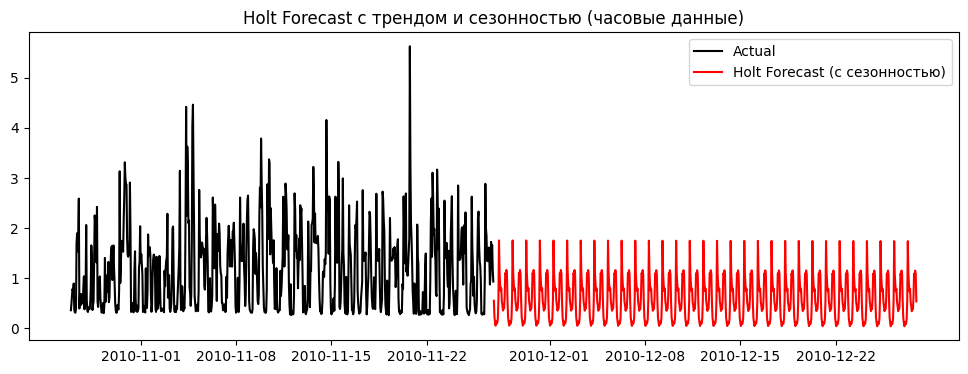

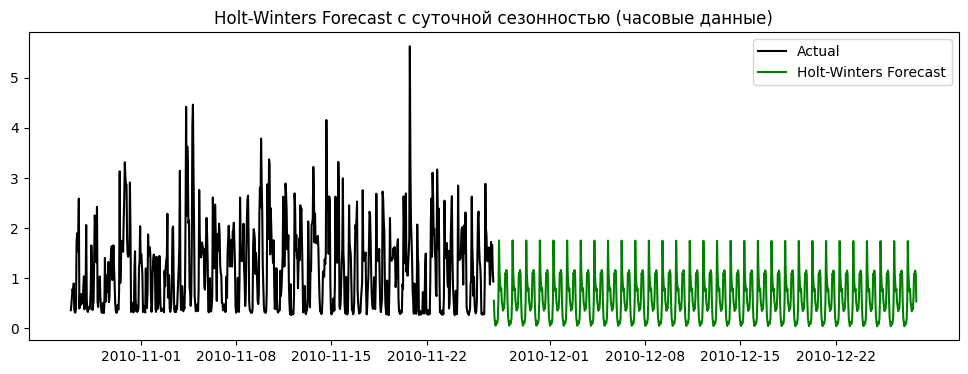

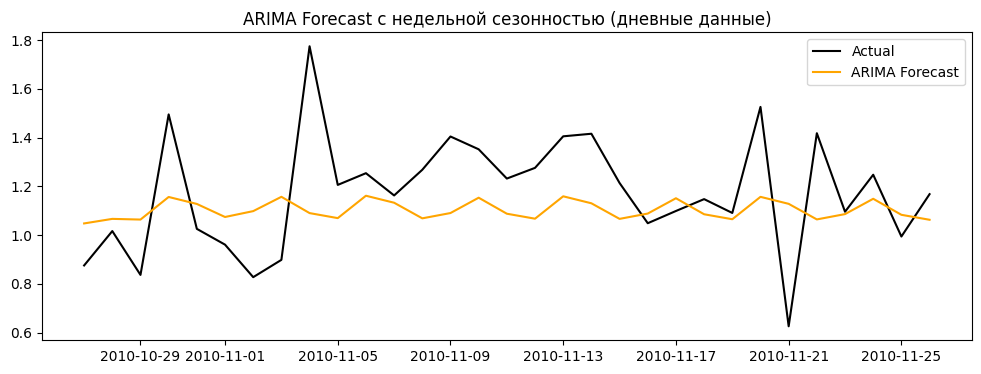

In [41]:
# ===== Прогноз за последний месяц с оптимизацией по памяти =====
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# ---- 1. Holt и Holt-Winters: часовые данные за год ----
last_year_start = ts.index.max() - pd.DateOffset(years=1)
ts_hourly_year = ts[ts.index >= last_year_start]

# Test: последний месяц
last_month_start = ts.index.max() - pd.DateOffset(months=1)
test_hourly = ts_hourly_year[ts_hourly_year.index >= last_month_start]

# Holt с сезонностью (24 часа)
holt_model = ExponentialSmoothing(ts_hourly_year, trend='add', seasonal='add', seasonal_periods=24)
holt_fit = holt_model.fit()
holt_forecast = holt_fit.forecast(len(test_hourly))

plt.figure(figsize=(12,4))
plt.plot(test_hourly, label='Actual', color='black')
plt.plot(holt_forecast, label='Holt Forecast (с сезонностью)', color='red')
plt.title("Holt Forecast с трендом и сезонностью (часовые данные)")
plt.legend()
plt.show()

# Holt-Winters с сезонностью (24 часа)
hw_model = ExponentialSmoothing(ts_hourly_year, trend='add', seasonal='add', seasonal_periods=24)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(len(test_hourly))

plt.figure(figsize=(12,4))
plt.plot(test_hourly, label='Actual', color='black')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title("Holt-Winters Forecast с суточной сезонностью (часовые данные)")
plt.legend()
plt.show()

# ---- 2. ARIMA: дневная агрегация за последний год ----
ts_daily = ts.resample('D').mean()
ts_daily_year = ts_daily[ts_daily.index >= (ts_daily.index.max() - pd.DateOffset(years=1))]

# Train: весь год минус последний месяц
last_month_start_daily = ts_daily_year.index.max() - pd.DateOffset(days=30)
train_arima = ts_daily_year[ts_daily_year.index < last_month_start_daily]
test_arima = ts_daily_year[ts_daily_year.index >= last_month_start_daily]

# ARIMA с фиксированными параметрами, сезонность m=7 (неделя)
arima_model = ARIMA(train_arima, order=(1,1,1), seasonal_order=(1,1,1,7))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(len(test_arima))

plt.figure(figsize=(12,4))
plt.plot(test_arima, label='Actual', color='black')
plt.plot(arima_forecast, label='ARIMA Forecast', color='orange')
plt.title("ARIMA Forecast с недельной сезонностью (дневные данные)")
plt.legend()
plt.show()



Метрики (дневной горизонт, последний месяц):
Seasonal Naive (7d dyn): MAE=0.2755 | RMSE=0.3501 | MAPE=26.51%
Moving Average (7d dyn): MAE=0.1885 | RMSE=0.2607 | MAPE=18.18%
Holt-Winters (daily): MAE=0.2051 | RMSE=0.2655 | MAPE=20.72%
SARIMAX (daily): MAE=0.2027 | RMSE=0.2606 | MAPE=20.77%


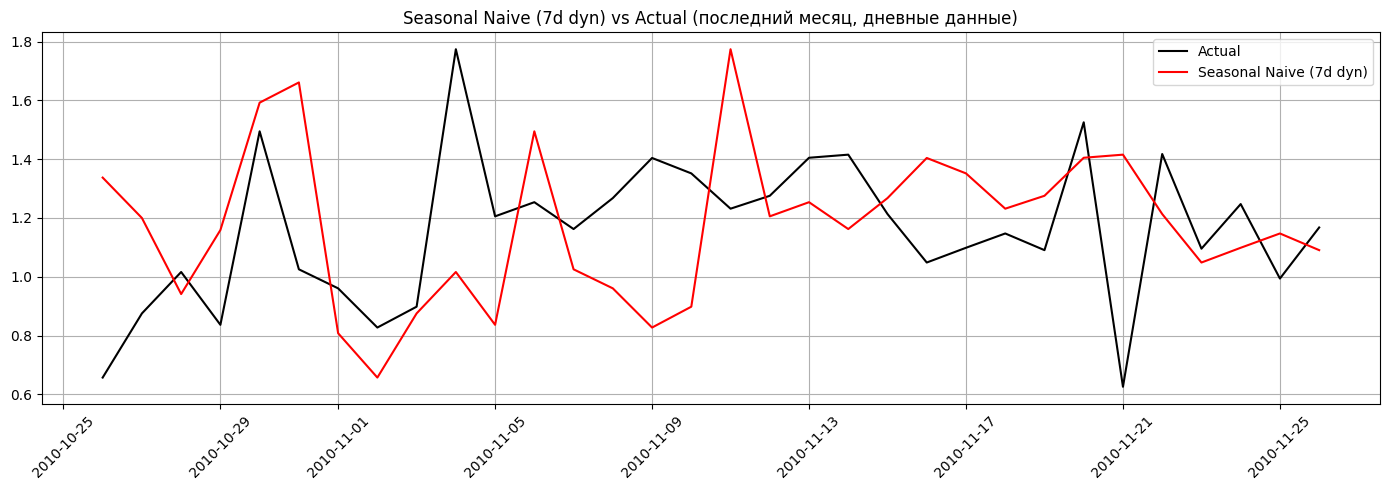

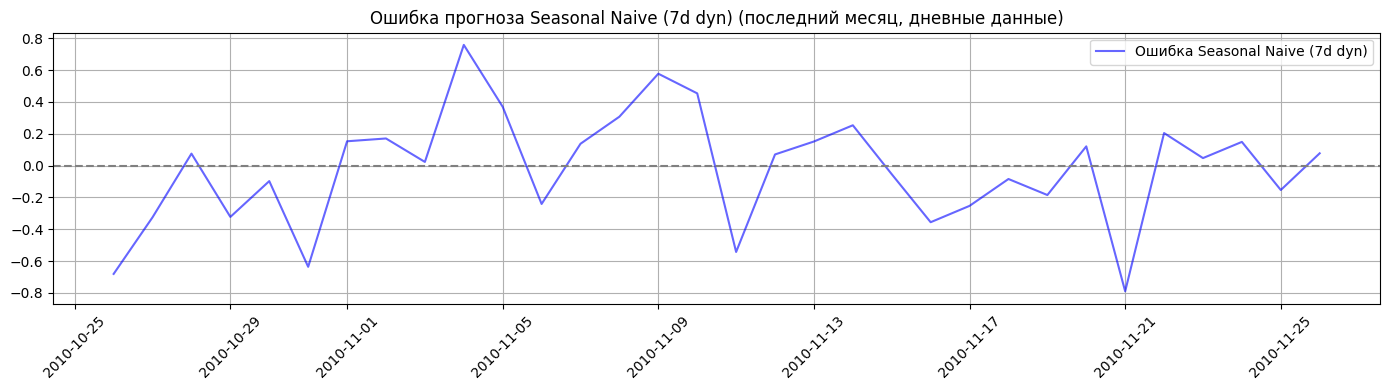

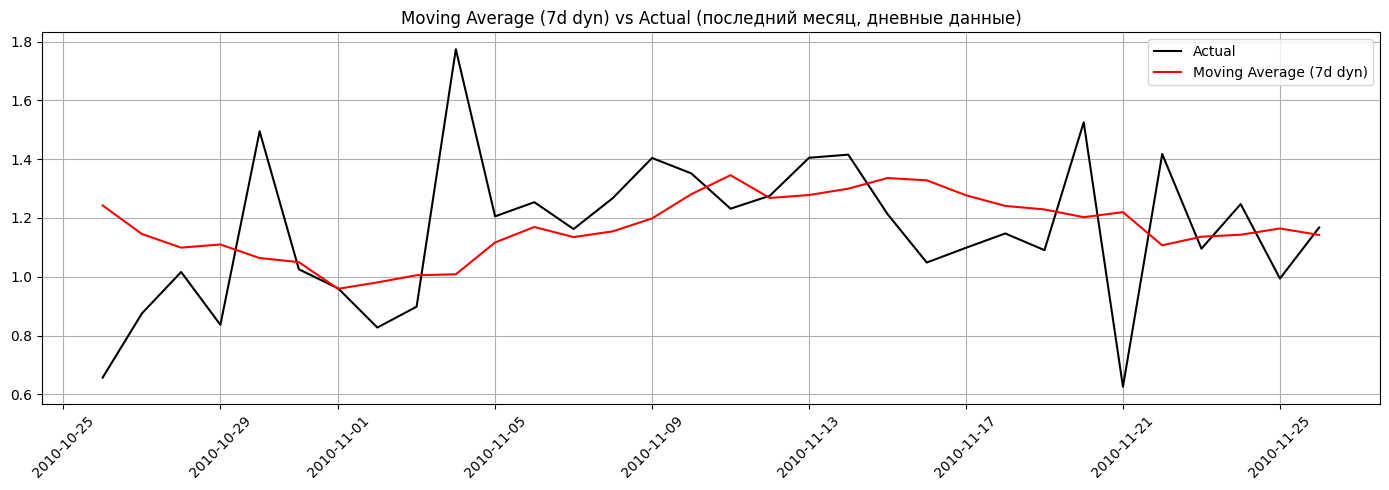

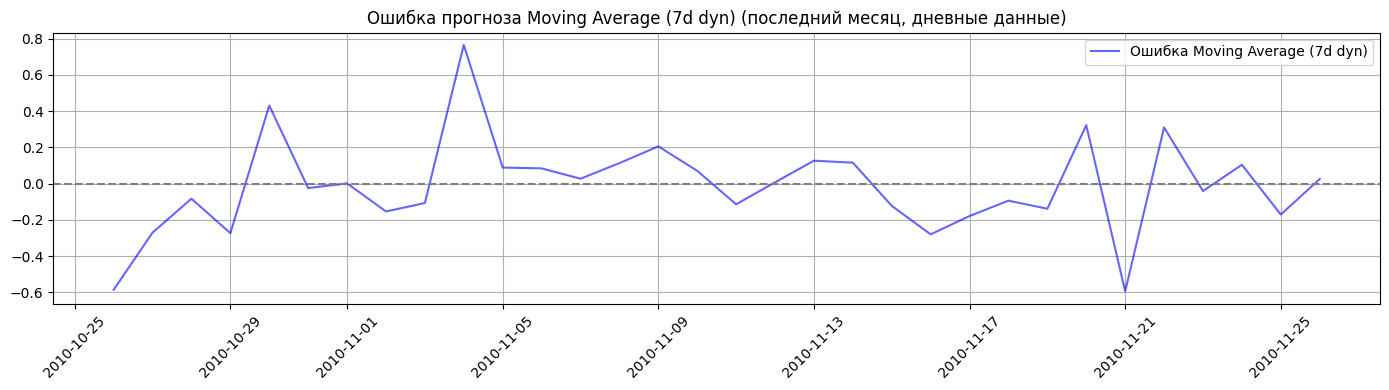

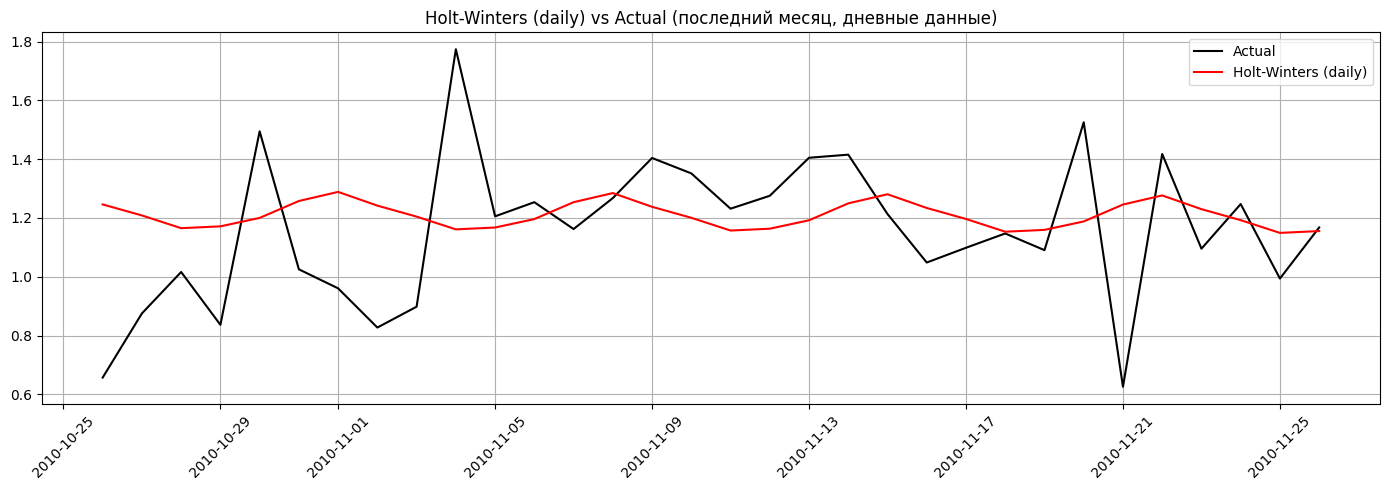

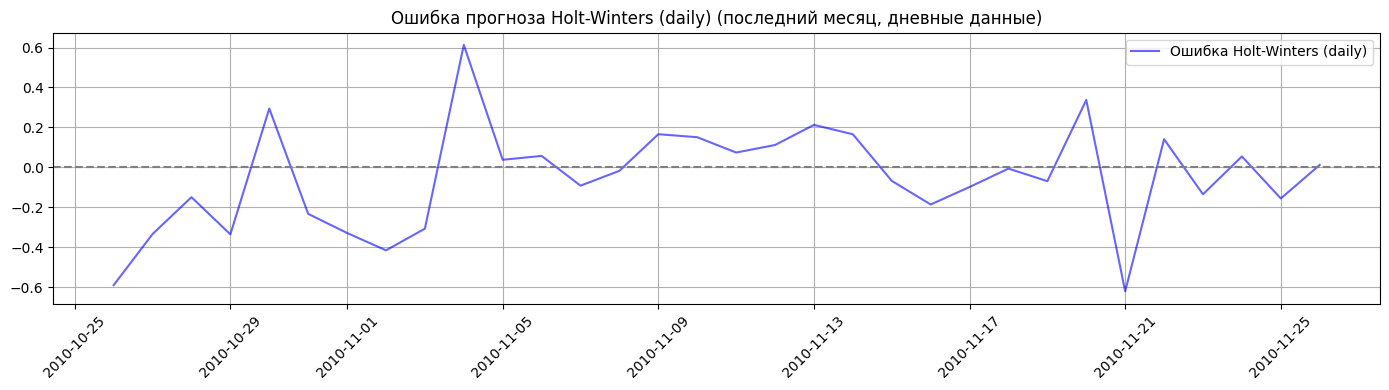

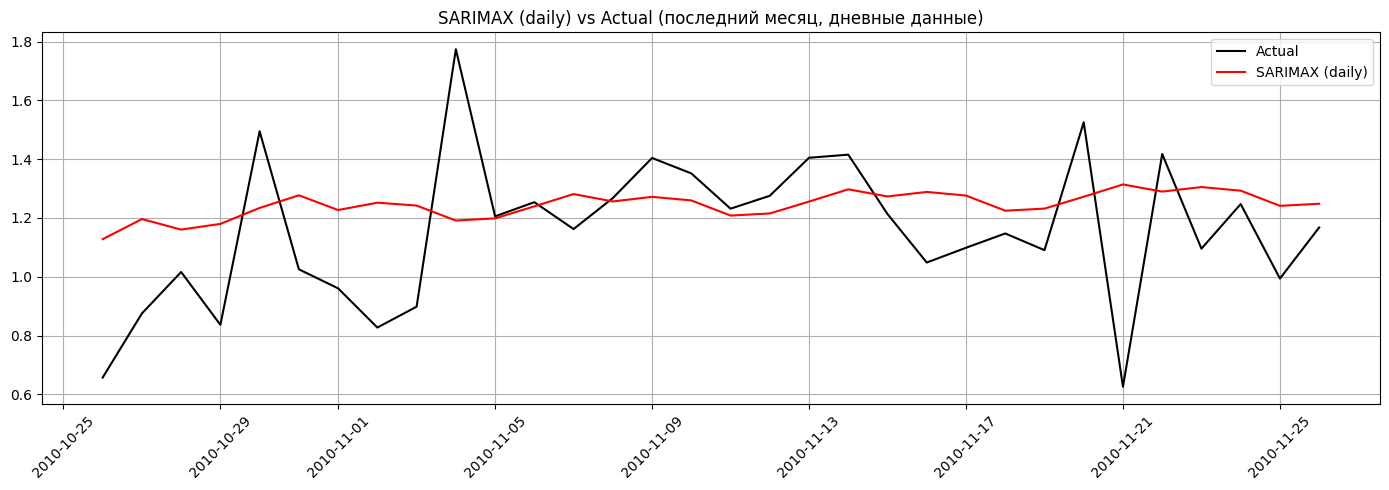

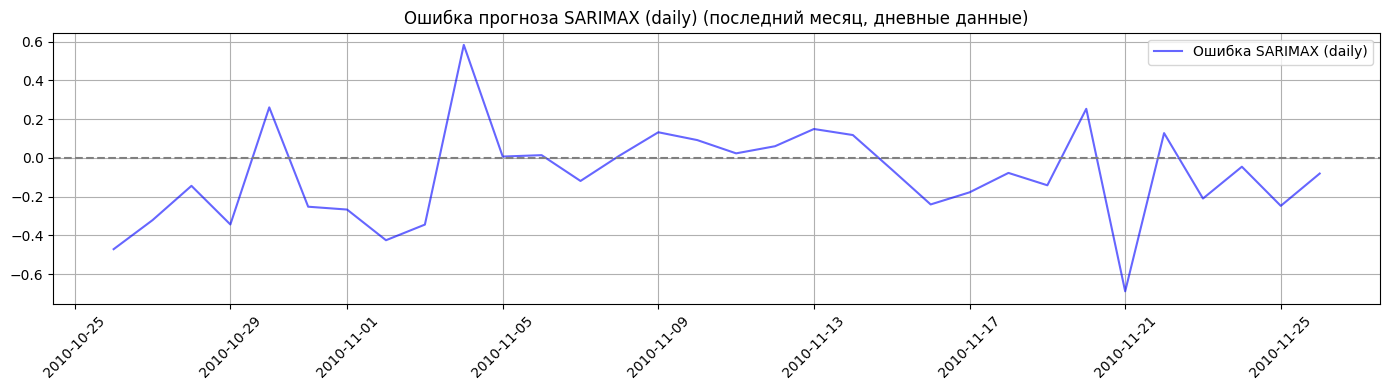

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===== 0. Подготовка =====
ts = ts.sort_index()
ts = ts.reindex(pd.date_range(ts.index.min(), ts.index.max(), freq="H"))
ts = ts.interpolate(method="linear", limit_direction="both").ffill().bfill()

# Агрегируем в дневные средние
ts_daily = ts.resample("D").mean().interpolate(method="linear").ffill().bfill()

# Последний месяц
last_month_start = ts_daily.index.max() - pd.DateOffset(months=1)
train_d = ts_daily[ts_daily.index < last_month_start].astype(float)
test_d  = ts_daily[ts_daily.index >= last_month_start].astype(float)

seasonal_periods = 7  # недельная сезонность

# ===== Вспомогательные =====
def evaluate(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100
    print(f"{name}: MAE={mae:.4f} | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

# ===== 1. Seasonal Naive (динамический) =====
naive_forecast = pd.Series(index=test_d.index, dtype=float)
for date in test_d.index:
    prev_date = date - pd.Timedelta(days=seasonal_periods)
    if prev_date in train_d.index:
        naive_forecast.loc[date] = train_d.loc[prev_date]
    elif prev_date in test_d.index:
        naive_forecast.loc[date] = test_d.loc[prev_date]
    else:
        naive_forecast.loc[date] = train_d.mean()

# ===== 2. Moving Average (динамический) =====
ma_forecast = pd.Series(index=test_d.index, dtype=float)
for i, date in enumerate(test_d.index):
    window = pd.concat([train_d, test_d.iloc[:i]])[-seasonal_periods:]
    ma_forecast.loc[date] = window.mean()

# ===== 3. Holt-Winters (дневные данные) =====
hw_model = ExponentialSmoothing(train_d, trend="add", seasonal="add", seasonal_periods=seasonal_periods)
hw_fit = hw_model.fit(optimized=True)
hw_forecast = pd.Series(hw_fit.forecast(len(test_d)), index=test_d.index)

# ===== 4. SARIMAX =====
sarimax_model = SARIMAX(train_d, order=(1,1,1), seasonal_order=(1,1,1,seasonal_periods))
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_forecast = pd.Series(sarimax_fit.forecast(len(test_d)), index=test_d.index)
# ===== Метрики =====
print("\nМетрики (дневной горизонт, последний месяц):")
evaluate("Seasonal Naive (7d dyn)", test_d, naive_forecast)
evaluate("Moving Average (7d dyn)", test_d, ma_forecast)
evaluate("Holt-Winters (daily)", test_d, hw_forecast)
evaluate("SARIMAX (daily)", test_d, sarimax_forecast)

# ===== Отдельные графики =====
models = {
    "Seasonal Naive (7d dyn)": naive_forecast,
    "Moving Average (7d dyn)": ma_forecast,
    "Holt-Winters (daily)": hw_forecast,
    "SARIMAX (daily)": sarimax_forecast
}

for name, forecast in models.items():
    # Прогноз vs фактические данные
    plt.figure(figsize=(14, 5))
    plt.plot(test_d, label="Actual", color="black")
    plt.plot(forecast, label=name, color="red")
    plt.title(f"{name} vs Actual (последний месяц, дневные данные)")
    plt.legend(); plt.grid(True)
    plt.xticks(rotation=45); plt.tight_layout()
    plt.show()

    # Ошибки прогноза
    errors = test_d - forecast
    plt.figure(figsize=(14, 4))
    plt.plot(errors, label=f"Ошибка {name}", color="blue", alpha=0.6)
    plt.axhline(0, linestyle="--", color="gray")
    plt.title(f"Ошибка прогноза {name} (последний месяц, дневные данные)")
    plt.legend(); plt.grid(True)
    plt.xticks(rotation=45); plt.tight_layout()
    plt.show()
